Imports

In [1]:
# Basics
import argparse
import os

# Data
import numpy as np
import pandas as pd

# Country codes
import pycountry

# Rasters - pixel data
import rasterio
from rasterio.features import rasterize

# Polygons - country outlines
from shapely.geometry import Polygon
import geopandas as gpd
from countryoutlines import CountryOutlines  # custom class


In [44]:
def latitude_square_area_matrix(lat_min, lat_max, pixels_lat, pixels_long):
    """Calculate m^2 area of an ndarray of wgs84 square pixels.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)

    higher = np.linspace(lat_max, lat_min, pixels_lat, endpoint=False)
    lower = np.append(higher[1:], lat_min)

    pixel_size = (lat_max - lat_min) / pixels_lat

    def subcalc(lats):
        sin_lats = np.sin(np.radians(lats))
        e_sin_lats = e*sin_lats
        zm = 1 - e_sin_lats
        zp = 1 + e_sin_lats
        return np.pi * b**2 * (np.arctanh(e_sin_lats) / e + sin_lats / (zp*zm))

    col = pixel_size / 360. * (subcalc(higher) - subcalc(lower))
    return col
    # return np.tile(col.reshape((-1, 1)), pixels_long)

In [5]:
def ilat(lat):
    return round((90 - lat) * 20)


def read_band(raster, window=None, return_affine=False):
    if window:
        band = raster.read(1, window=window)
        affine = raster.window_transform(window)
    else:
        band = raster.read(1)
        affine = raster.transform

    if return_affine:
        return (band, affine)
    else:
        return band

In [6]:

cancer = 23.4394
capricorn = -23.4394

# outlines = {code: None for code in df.code.unique()}

def get_geom(code):
    outline_gdf = CountryOutlines.load_country(code)
    return outline_gdf.geometry[0]

tropicTop = ilat(cancer)
tropicBottom = ilat(capricorn)


In [109]:
os.listdir("/Volumes/Balrog/RA/")

['.DS_Store',
 'VCF5KYR_1982001_001_2018224204211.tif',
 'VCF5KYR_1983001_001_2018224204436.tif',
 'VCF5KYR_1984001_001_2018224204542.tif',
 'VCF5KYR_1985001_001_2018224204542.tif',
 'VCF5KYR_1986001_001_2018224204727.tif',
 'VCF5KYR_1987001_001_2018224204756.tif',
 'VCF5KYR_1988001_001_2018224204838.tif',
 'VCF5KYR_1989001_001_2018224204904.tif',
 'VCF5KYR_1990001_001_2018224204938.tif',
 'VCF5KYR_1991001_001_2018224205008.tif',
 'VCF5KYR_1992001_001_2018224205034.tif',
 'VCF5KYR_1993001_001_2018224205123.tif',
 'VCF5KYR_1995001_001_2018224205251.tif',
 'VCF5KYR_1996001_001_2018224205332.tif',
 'VCF5KYR_1997001_001_2018224205415.tif',
 'VCF5KYR_1998001_001_2018224205440.tif',
 'VCF5KYR_1999001_001_2018224205513.tif',
 'VCF5KYR_2001001_001_2018224205557.tif',
 'VCF5KYR_2002001_001_2018224205629.tif',
 'VCF5KYR_2003001_001_2018224205710.tif',
 'VCF5KYR_2004001_001_2018224205736.tif',
 'VCF5KYR_2005001_001_2018224205812.tif',
 'VCF5KYR_2006001_001_2018224205841.tif',
 'VCF5KYR_2007001_00

1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1995
1996
1997
1998
1999
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


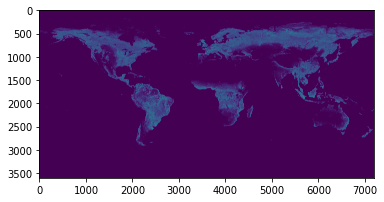

In [119]:
folder = "data/raw"
folder = "/Volumes/Balrog/RA"
files = os.listdir(folder)
f = [f"{folder}/{f}" for f in files if f.startswith("VCF5KYR")]
f = [file for file in f if f"VCF5KYR" in file]
# a = np.array([0.,0])
# b = np.array([0.,0])
df = pd.read_csv("interim/country_bounds.csv")
df = df.groupby("code").head(1)
df = pd.concat([df.copy().assign(tropics=tropics) for tropics in (False, True)], ignore_index=True)
df = df.sort_values(by=["code", "tropics"]).reset_index(drop=True)
country_codes = df.loc[::2, "code"].iteritems()
f.sort()
a = np.zeros((3600,7200),dtype=np.float64)
years = len(f)
for year in range(1982,2017):

    
    file = [(i, file) for i, file in enumerate(f) if f"_{year}" in file]
    if not file:
        continue
    
    i, file2 = file[0]
    if year == 1982:
        file1 = file2
    elif i == 0:
        continue
    else:
        file1 = f[i-1]

    with rasterio.open(file1) as raster1, \
        rasterio.open(file2) as raster2:

        cover, affine = read_band(raster2, return_affine=True)
        non_tree_veg = raster2.read(2)
        bare = raster2.read(3)

        gain = cover * 1.0 - raster1.read(1)
        loss = gain.copy() * -1
        gain[gain < 0] = 0
        loss[loss < 0] = 0
        print(year)
        # cover = cover / 100.0
        a += loss
        
        # geom = np.load("interim/geom.npy")
        geom = np.load("interim/geom.npy")
        geom1 = geom.copy()
        geom1[geom >= 0] = geom1[geom >= 0] % 2
        geom1 = np.reshape(geom1, geom.shape)
        # Area in m^2
        area = np.load("interim/area.npy") 
        
        mask = geom >= 0
        geom = geom[mask]
        geom1 = geom1[mask]
        area = area[mask]
        cover = cover[mask]
        gain = gain[mask]
        loss = loss[mask]
        non_tree_veg = non_tree_veg[mask]
        bare = bare[mask]

        pos = cover > 0
        cover_cat = cover.copy()
        # print(cover.sum())
        cover_cat[pos] = (cover[pos] - 1) // 25 + 1
        # print(cover.sum())
        df1 = pd.concat([df.copy().assign(cover_cat=cc)
                        for cc in ["0", "1-25", "26-50", "51-75", "76-100"]], ignore_index=True)
        df1 = df1.sort_values(by=["code", "tropics", "cover_cat"]).reset_index(drop=True)

        geom_cat = geom * 5 + cover_cat
        del geom, cover_cat

        nrows = df1.shape[0]

        data_cover = np.minimum((cover + non_tree_veg + bare),100)
        # area = area
        df1["pixels"] = np.bincount(geom_cat, weights=data_cover, minlength=nrows) / 100
        df1["area"] = np.bincount(geom_cat, weights=area*data_cover, minlength=nrows) / 100

        area_cover = area*cover
        area_loss = area*loss
        area_gain = area*gain
        del area, cover
        
        df1["cover"] = np.bincount(geom_cat, weights=area_cover, minlength=nrows) / 100
        df1["gain"] = np.bincount(geom_cat, weights=area_gain, minlength=nrows) / 100
        df1["loss"] = np.bincount(geom_cat, weights=area_loss, minlength=nrows) / 100
        # a += np.array(np.bincount(geom1, weights=loss) / 100 / 1000**2, dtype=np.float64)
        # b += np.array(np.bincount(geom1, weights=area_loss) / 100 / 1000**2, dtype=np.float64)

        del area_cover, geom_cat
    
    df1["year"] = year
    # df1.to_csv(f"interim/Pre-2000/stats_{year}.csv")       
# print(a)
# print(b)
plt.imshow(a/years)

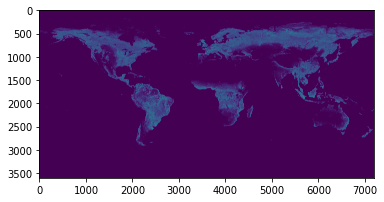

In [120]:
plt.imshow(a)

In [82]:
print(3371598744738119.5 / 1000**2 / 1000 / 100)
# print(147983922 * 25)
# latitude_square_area_matrix(45,45.5,1,1) / 1000**2
np.array([True, False, False, False]) | np.array([False, True, False, False]) | np.array([False, False, True, False])

33715.987447381194


array([ True,  True,  True, False])

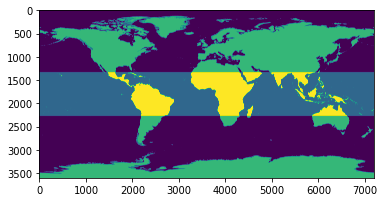

In [107]:
from matplotlib import pyplot as plt
geom = np.load("interim/geom.npy")
geom1 = geom.copy()
geom2 = geom.copy()
geom1[geom >= 0] = geom1[geom >= 0] % 2
geom1 = np.reshape(geom1, geom.shape)
plt.imshow(geom1)
plt.show()

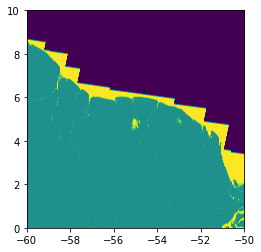

In [67]:
def read_band(raster, window=None, return_affine=False):
    if window:
        band = raster.read(1, window=window)
        affine = raster.window_transform(window)
    else:
        band = raster.read(1)
        affine = raster.transform

    if return_affine:
        return (band, affine)
    else:
        return band

tile = Tile(10,-60)
with tile.load_data(DataType.datamask) as mask_raster:
    show((mask_raster, 1))
    

Create rectangle for calculations by tropics

In [5]:

cancer = 23.4372
capricorn = -23.4394
tropics = Polygon([(-180,cancer),(-180,capricorn),(180,capricorn),(180,cancer)])
tropics = gpd.GeoDataFrame(geometry=[tropics])

plot = False
if plot:
    ax = tropics.plot(facecolor=(1,1,1,0.4), edgecolor='white', linewidth=0.5)

    with rasterio.open("data/raw/VCF5KYR_1982001_001_2018224204211.tif") as f:
        b1 = f.read(1)
        b2 = f.read(2)
        b3 = f.read(3)
        bands = np.stack((b1,b2,b3),axis=0) / 100

        show(bands, transform=f.transform, ax=ax)

    del b1, b2, b3, bands, f

Start computing means

In [47]:
def area_of_pixels(lat_start, lat_end, n_pixels):
    """Calculate m^2 area of an ndarray of wgs84 square pixels.

    Adapted from: https://gis.stackexchange.com/a/127327/2397
    
    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    lower = np.linspace(lat_start, lat_end, n_pixels, endpoint=False)
    
    higher = np.append(lower[1:], lat_end)
    pixel_size = (lat_end - lat_start) / n_pixels
    def subcalc(lats):
        sin_lats = np.sin(np.radians(lats))
        e_sin_lats = e*sin_lats
        zm = 1 - e_sin_lats
        zp = 1 + e_sin_lats
        return np.pi * b**2 * (np.arctanh(e_sin_lats) / e + sin_lats / (zp*zm))

    return pixel_size / 360. * (subcalc(higher) - subcalc(lower))

In [44]:
# area_of_pixels(0, )
test = "3077.2300079"  # official number for pixel going 30' north of equator
# TODO cite source

test2 = area_of_pixels(0,0.5,4)

np.tile(test2.reshape((-1,1)), (1,4))

array([[1.92329103e+08, 1.92329103e+08, 1.92329103e+08, 1.92329103e+08],
       [1.92328212e+08, 1.92328212e+08, 1.92328212e+08, 1.92328212e+08],
       [1.92326430e+08, 1.92326430e+08, 1.92326430e+08, 1.92326430e+08],
       [1.92323757e+08, 1.92323757e+08, 1.92323757e+08, 1.92323757e+08]])